In [1]:
import json
import os
from shapely.geometry import shape, GeometryCollection, Point, Polygon
import pandas as pd
import random
from xml.dom import minidom 

In [2]:
directory = "shapes"
neighbourhoods = {}
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
      with open(f) as file:
        geojson = json.load(file)
        neighbourhoods[filename.split(".")[0]] = Polygon(geojson["coordinates"][0][0])

In [3]:
neighbourhoods["UniaodasfreguesiasdeAldoarFozdoDouroeNevogilde"] = neighbourhoods["Aldoar"].union(neighbourhoods["FozDoDouro"]).union(neighbourhoods["Nevogilde"])
neighbourhoods["UniaodasfreguesiasdeLordelodoOuroeMassarelos"] = neighbourhoods["LordeloDeOuro"].union(neighbourhoods["Massarelos"])
del neighbourhoods["Aldoar"]
del neighbourhoods["FozDoDouro"]
del neighbourhoods["Nevogilde"]
del neighbourhoods["LordeloDeOuro"]
del neighbourhoods["Massarelos"]

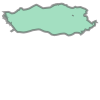

In [4]:
polys = list(neighbourhoods.values())
poly = polys.pop()
while len(polys) > 0:
    poly = poly.union(polys.pop())
poly

In [5]:
movementsDF = pd.read_csv("movimentos_porto_por_freguesia.csv")
movementsDF

freguesia genero   ocupacao  \
0                                             Paranhos      H  Estudante   
1                                             Paranhos      H  Estudante   
2                                             Paranhos      M  Empregada   
3                                             Paranhos      M  Empregada   
4                                             Paranhos      M  Estudante   
..                                                 ...    ...        ...   
139  União das freguesias de Lordelo do Ouro e Mass...      H      Total   
140  União das freguesias de Lordelo do Ouro e Mass...     HM  Empregada   
141  União das freguesias de Lordelo do Ouro e Mass...      H  Estudante   
142  União das freguesias de Lordelo do Ouro e Mass...     HM  Estudante   
143  União das freguesias de Lordelo do Ouro e Mass...      M  Empregada   

                                  destino  valor  
0     Na freguesia onde reside atualmente   1903  
1    No mesmo município, noutra freguesia   1221  
2    No mesmo município, noutra freguesia   3802  
3     Na freguesia onde reside atualmente   2224  
4    No mesmo município, noutra freguesia   1289  
..                                    ...    ...  
139  No mesmo município, noutra freguesia   3208  
140   Na freguesia onde reside atualmente   1996  
141   Na freguesia onde reside atualmente    986  
142   Na freguesia onde reside atualmente   1955  
143  No mesmo município, noutra freguesia   2508  

[144 rows x 5 columns]

In [6]:
movementsDF = movementsDF[(movementsDF["genero"] == "HM") & (movementsDF["ocupacao"] == "Total")].reset_index(drop=True)
movementsDF

freguesia genero ocupacao  \
0                                            Paranhos     HM    Total   
1                                            Paranhos     HM    Total   
2   União das freguesias de Cedofeita, Santo Ildef...     HM    Total   
3   União das freguesias de Cedofeita, Santo Ildef...     HM    Total   
4                                            Paranhos     HM    Total   
5                                            Paranhos     HM    Total   
6   União das freguesias de Aldoar, Foz do Douro e...     HM    Total   
7   União das freguesias de Aldoar, Foz do Douro e...     HM    Total   
8                                              Bonfim     HM    Total   
9                                              Bonfim     HM    Total   
10                                           Campanhã     HM    Total   
11                                           Campanhã     HM    Total   
12                                            Ramalde     HM    Total   
13                                            Ramalde     HM    Total   
14  União das freguesias de Lordelo do Ouro e Mass...     HM    Total   
15  União das freguesias de Lordelo do Ouro e Mass...     HM    Total   

                                 destino  valor  
0   No mesmo município, noutra freguesia   9362  
1    Na freguesia onde reside atualmente   7372  
2    Na freguesia onde reside atualmente   6085  
3   No mesmo município, noutra freguesia   7105  
4   No mesmo município, noutra freguesia    172  
5    Na freguesia onde reside atualmente    188  
6   No mesmo município, noutra freguesia   6674  
7    Na freguesia onde reside atualmente   4261  
8   No mesmo município, noutra freguesia   4946  
9    Na freguesia onde reside atualmente   3043  
10   Na freguesia onde reside atualmente   3724  
11  No mesmo município, noutra freguesia   5841  
12  No mesmo município, noutra freguesia   9808  
13   Na freguesia onde reside atualmente   4982  
14  No mesmo município, noutra freguesia   6912  
15   Na freguesia onde reside atualmente   3951

In [7]:
movementsDF["freguesia"] = movementsDF["freguesia"].apply(lambda x: x.replace(" ","").replace("ã","a").replace(",","").replace("é","e").replace("ó","o"))

In [8]:
def generate_random_point_within_polygon(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    while True:
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(random_point):
            return random_point.x, random_point.y

In [9]:
def generate_point(_from, to):
    return [generate_random_point_within_polygon(_from), generate_random_point_within_polygon(to)]

In [66]:
REDUCTION_FACTOR = 0.1
points = []
for idx, row in movementsDF.iterrows():
    n_agents = int(row["valor"]*REDUCTION_FACTOR)
    for _ in range(n_agents):
        if "noutra" in row["destino"]:
            others = list(neighbourhoods.keys())
            others.remove(row["freguesia"])
            other = random.choice(others)
            points.append(generate_point(neighbourhoods[row["freguesia"]], neighbourhoods[other]))
        else:
            points.append(generate_point(neighbourhoods[row["freguesia"]], neighbourhoods[row["freguesia"]]))

len(points)

8437

In [67]:
final = {}
for person, (home, work) in enumerate(points):
    time_home = f"{random.randint(6,12)}:{random.randint(0,59)}:00"
    time_work = f"{random.randint(16,20)}:{random.randint(0,59)}:00"
    act_home = ["h", home[0], home[1], time_home]
    act_work = ["w", work[0], work[1], time_work]
    final[f"commuter_{person+1}"] = [act_home, act_work, act_home]

final

{'commuter_1': [['h', -8.608578534263156, 41.1838565521962, '9:16:00'],
  ['w', -8.597128818673996, 41.15885039775705, '19:5:00'],
  ['h', -8.608578534263156, 41.1838565521962, '9:16:00']],
 'commuter_2': [['h', -8.617899053162116, 41.16651497992873, '7:10:00'],
  ['w', -8.668833115261759, 41.170796978454895, '17:27:00'],
  ['h', -8.617899053162116, 41.16651497992873, '7:10:00']],
 'commuter_3': [['h', -8.589348167563175, 41.174656705986166, '11:58:00'],
  ['w', -8.670548780779873, 41.15941439699535, '20:5:00'],
  ['h', -8.589348167563175, 41.174656705986166, '11:58:00']],
 'commuter_4': [['h', -8.591843772599612, 41.177284018759785, '10:38:00'],
  ['w', -8.678381365538678, 41.16077242958604, '18:51:00'],
  ['h', -8.591843772599612, 41.177284018759785, '10:38:00']],
 'commuter_5': [['h', -8.58686462494323, 41.17819725353683, '9:6:00'],
  ['w', -8.666768115622618, 41.16246670228954, '20:18:00'],
  ['h', -8.58686462494323, 41.17819725353683, '9:6:00']],
 'commuter_6': [['h', -8.609864204

In [68]:
imp = minidom.getDOMImplementation()
doctype = imp.createDocumentType("plans", None, "http://www.matsim.org/files/dtd/plans_v4.dtd")
root = imp.createDocument(None, "plans", doctype)

plansEl = root.documentElement

for person, plans in final.items():
    personEl = root.createElement("person")
    personEl.setAttribute("id", str(person))
    
    planEl = root.createElement("plan")
    for i, plan in enumerate(plans):
        _type, x, y, time = plan
        actEl = root.createElement("act")
        actEl.setAttribute("type", _type)
        actEl.setAttribute("x", str(round(x, 10)))
        actEl.setAttribute("y", str(round(y, 10)))
        actEl.setAttribute("end_time", time)

        planEl.appendChild(actEl)
        if i != len(plans) - 1:
            legEl = root.createElement("leg")
            legEl.setAttribute("mode", "car")
            planEl.appendChild(legEl)

    personEl.appendChild(planEl)

    plansEl.appendChild(personEl)

xml_str = root.toprettyxml(indent="\t")

with open("../input/plans.xml", "w") as f:
    f.write(xml_str)

print(xml_str)

<?xml version="1.0" ?>
<!DOCTYPE plans
  SYSTEM 'http://www.matsim.org/files/dtd/plans_v4.dtd'>
<plans>
	<person id="commuter_1">
		<plan>
			<act type="h" x="-8.6085785343" y="41.1838565522" end_time="9:16:00"/>
			<leg mode="car"/>
			<act type="w" x="-8.5971288187" y="41.1588503978" end_time="19:5:00"/>
			<leg mode="car"/>
			<act type="h" x="-8.6085785343" y="41.1838565522" end_time="9:16:00"/>
		</plan>
	</person>
	<person id="commuter_2">
		<plan>
			<act type="h" x="-8.6178990532" y="41.1665149799" end_time="7:10:00"/>
			<leg mode="car"/>
			<act type="w" x="-8.6688331153" y="41.1707969785" end_time="17:27:00"/>
			<leg mode="car"/>
			<act type="h" x="-8.6178990532" y="41.1665149799" end_time="7:10:00"/>
		</plan>
	</person>
	<person id="commuter_3">
		<plan>
			<act type="h" x="-8.5893481676" y="41.174656706" end_time="11:58:00"/>
			<leg mode="car"/>
			<act type="w" x="-8.6705487808" y="41.159414397" end_time="20:5:00"/>
			<leg mode="car"/>
			<act type="h" x="-8.58934816